## Loading Image datasetset

In [2]:
import numpy as np

# Load the .npz file
data = np.load('dataset_features.npz')

# List all arrays within the .npz file
print(data.files)

# Access individual arrays by their names
X_train = data['trainset_features']
y_train = data['trainset_labels']

X_val = data['validset_features']
y_val = data['validset_labels']

X_test = data['testset_features']
y_test = data['testset_labels']

class_labels = data['class_labels']

['trainset_features', 'validset_features', 'testset_features', 'trainset_labels', 'validset_labels', 'testset_labels', 'class_labels']


In [3]:
def decode_class(y):
    return np.argmax(y,axis=1)

## Model training

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a k-NN pipeline
logreg_pipe = Pipeline(
    [("scaler", StandardScaler()), 
     ("logreg", LogisticRegression(multi_class='multinomial', solver='saga', penalty='none'))]
)

# Fit it to train data
logreg_pipe.fit(X_train, decode_class(y_train))

# Accuracy on train, validation and test sets
print('Model Accuracy:')
print(f'On train set: {logreg_pipe.score(X_train, decode_class(y_train)):.3f}')
print(f'On valid set: {logreg_pipe.score(X_val, decode_class(y_val)):.3f}')
print(f'On test  set: {logreg_pipe.score(X_test, decode_class(y_test)):.3f}')

Model Accuracy:
On train set: 1.000
On valid set: 0.914
On test  set: 0.960


/home/miguel/miniconda3/envs/adsml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Visualization of model coefficients

In [5]:
coefficients = logreg_pipe.named_steps['logreg'].coef_ 
coefficients.shape

(6, 1280)

Visualize the coefficients as a heatmap

Text(0.5, 1.0, 'Logistic Regression Coefficients Heatmap')

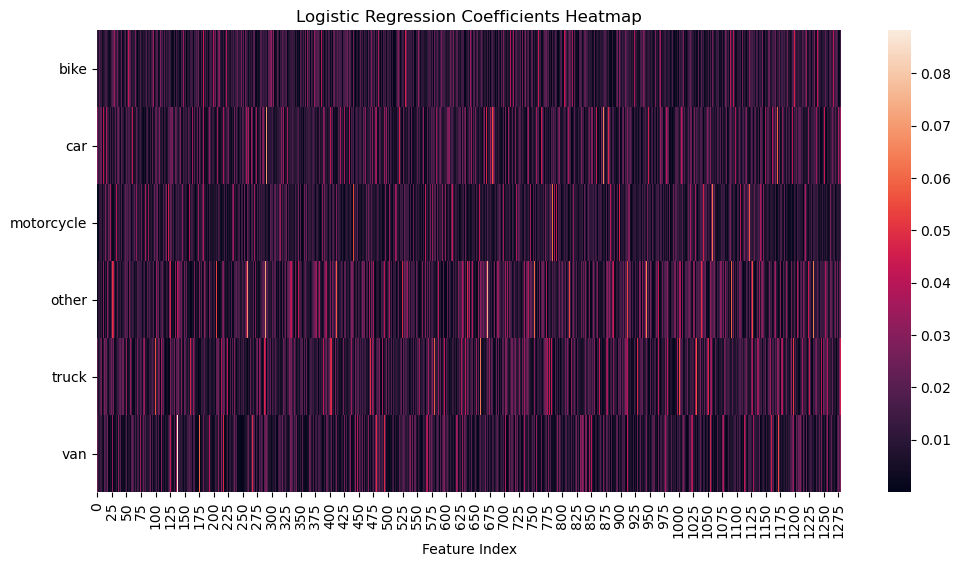

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(np.abs(coefficients), annot=False, cbar=True)
ax.set_yticklabels(class_labels, rotation=0)
ax.set_xlabel("Feature Index")
plt.title("Logistic Regression Coefficients Heatmap")

Find the indices of the top 5 largest coefficients (absolute values) for each class

In [8]:
import pandas as pd

top_features = {}
for class_index, class_coefficients in enumerate(coefficients):
    # Get the indices of the top 5 largest coefficients for the current class
    largest_indices = np.argsort(-np.abs(class_coefficients))[:5]
    top_features[f"{class_labels[class_index]}"] = largest_indices


top_features_df = pd.DataFrame.from_dict(top_features, orient='index', columns=[f"Feature {i+1}" for i in range(5)])
print("Top 5 Largest Coefficients for Each Class (Feature Indices):")
print(top_features_df)

Top 5 Largest Coefficients for Each Class (Feature Indices):
            Feature 1  Feature 2  Feature 3  Feature 4  Feature 5
bike              801        999       1128       1233        530
car               291        871       1047        892       1170
motorcycle       1058        783       1122        441        787
other             671        289        258        945       1232
truck             794        378        659        139        555
van               138        576        176        765       1172


## Model regularization

In [9]:
X_crossval = np.concatenate((X_train, X_val), axis=0)
y_crossval = decode_class(np.concatenate((y_train, y_val), axis=0))

In [11]:
from sklearn.model_selection import GridSearchCV

# Define logistic regression model with L2 regularization
log_reg = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, multi_class='multinomial')

# Define grid of regularization strengths to test
param_grid = {
    'C': np.logspace(-6, 3, 20)  # Test values from 10^-4 to 10^4
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='accuracy',  # Metric for evaluating models
    cv=5,                # 5-fold cross-validation
    n_jobs=-1,           # Use all available processors
    return_train_score=True
)

# Perform grid search
grid_search.fit(X_crossval, y_crossval)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000,
                                          multi_class='multinomial'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-06, 2.97635144e-06, 8.85866790e-06, 2.63665090e-05,
       7.84759970e-05, 2.33572147e-04, 6.95192796e-04, 2.06913808e-03,
       6.15848211e-03, 1.83298071e-02, 5.45559478e-02, 1.62377674e-01,
       4.83293024e-01, 1.43844989e+00, 4.28133240e+00, 1.27427499e+01,
       3.79269019e+01, 1.12883789e+02, 3.35981829e+02, 1.00000000e+03])},
             return_train_score=True, scoring='accuracy')

In [12]:
# Extract results from the GridSearchCV object
results = pd.DataFrame(grid_search.cv_results_)

# Select relevant columns for interpretation
results_df = results[
    [
        'param_C',  # Regularization strength parameter
        'mean_train_score',  # Mean training score across folds
        'std_train_score',  # Standard deviation of training score across folds
        'mean_test_score',  # Mean validation (test) score across folds
        'std_test_score'  # Standard deviation of validation score across folds
    ]
]

# Sort by the validation score for better interpretability
results_df = results_df.sort_values(by='mean_test_score', ascending=False)
results_df

,param_C,mean_train_score,std_train_score,mean_test_score,std_test_score
15,12.74275,1.000000,0.000000,0.906942,0.017391
9,0.01833,0.995226,0.001465,0.906913,0.019082
14,4.281332,1.000000,0.000000,0.904532,0.016842
13,1.43845,1.000000,0.000000,0.904532,0.016842
8,0.006158,0.988065,0.004225,0.904532,0.026086
10,0.054556,1.000000,0.000000,0.902151,0.019024
17,112.883789,1.000000,0.000000,0.902151,0.019024
16,37.926902,1.000000,0.000000,0.902151,0.019024
12,0.483293,1.000000,0.000000,0.902151,0.019024
19,1000.0,1.000000,0.000000,0.899742,0.009729


- **mean_train_score** and **std_train_score** focus on the model's fit to the training data.
- **mean_test_score** and **std_test_score** assess the model's ability to generalize to unseen data.
    
    Consistency and Stability:
        Low standard deviations (**std_train_score** and **std_test_score**) indicate consistent performance.
        High mean validation scores with low standard deviations are desirable for a robust, well-generalizing model.

These metrics help diagnose overfitting, underfitting, or data-related issues during hyperparameter tuning.

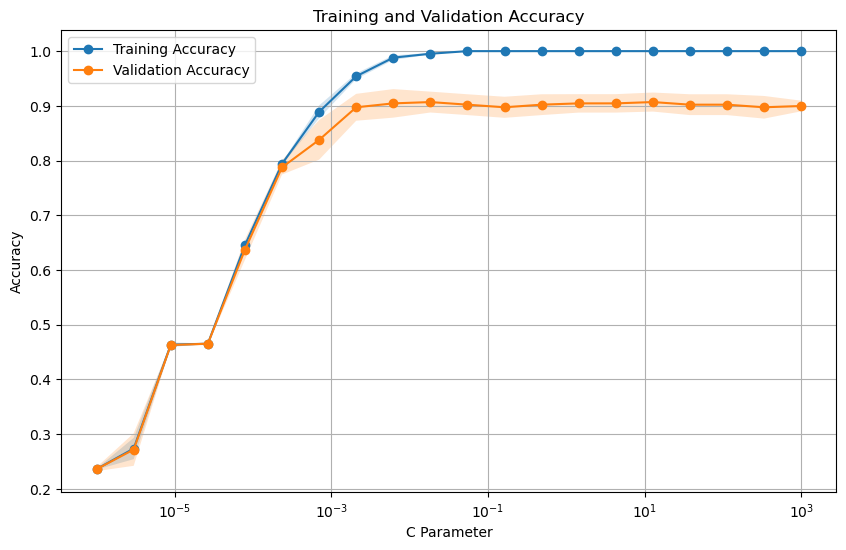

In [29]:
# Assuming you have metrics recorded during training, such as accuracy or loss
# Example data (replace with actual metrics from your training process)

results_df = results_df.sort_values(by='param_C')

param_c = results_df['param_C'].tolist()
train_scores_mean = results_df['mean_train_score'].to_numpy()
val_scores_mean = results_df['mean_test_score'].to_numpy()
train_scores_std = results_df['std_train_score'].to_numpy()
val_scores_std = results_df['std_test_score'].to_numpy()
# Replace with validation accuracies

# Plot the curves
plt.figure(figsize=(10, 6))
plt.plot(param_c, train_scores_mean, label="Training Accuracy", marker="o")
plt.plot(param_c, val_scores_mean, label="Validation Accuracy", marker="o")
plt.fill_between(param_c, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.fill_between(param_c, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2)
plt.title("Training and Validation Accuracy")
plt.xlabel("C Parameter")
plt.ylabel("Accuracy")
plt.xscale('log')
plt.legend()
plt.grid()

We observe that for values of C > 0.001 the model starts to overfitting and not gaining anymore capability to generalize. This is indicated by a gap showing in the model accuracy of the training and validation sets.